In [180]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.utils.multiclass import unique_labels

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from PIL import Image as PilImage

import lightning as pl
from lightning.pytorch import Trainer
from lightning.pytorch.loggers import TensorBoardLogger

from omnixai.data.image import Image
from omnixai.explainers.vision.specific.gradcam.pytorch.gradcam import GradCAM


In [181]:
# Load the test image
img = Image(PilImage.open('/home/justin/Desktop/Resume/Github/Explainable-AI/data/test/virus/person8_virus_28.jpeg').convert('RGB'))
img2 = Image(PilImage.open('/home/justin/Desktop/Resume/Github/Explainable-AI/data/test/bacteria/person1474_bacteria_3837.jpeg').convert('RGB'))

In [182]:
# The preprocessing model
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
preprocess = lambda ims: torch.stack([transform(im.to_pil()) for im in ims])

In [183]:
model_cam = models.mobilenet_v2(pretrained=True)

In [184]:
explainer = GradCAM(
    model=model_cam,
    target_layer=model_cam.features[-1][-1],
    preprocess_function=preprocess
)

In [185]:
# Explain the top label
explanations = explainer.explain(img)
explanations.ipython_plot(index=0, class_names="virus")

Added markdown image to visualise output
![grad_virus](../images/gradcam1.png)

In [186]:
# Explain the top label
explanations = explainer.explain(img2)
explanations.ipython_plot(index=0, class_names="bacteria")

Added markdown image to visualise output
![grad_virus](../images/gradcam2.png)

In [187]:
path = "/home/justin/Desktop/Resume/Github/Explainable-AI/data"

In [188]:
onlyfiles = [os.path.join(dirpath,f) for (dirpath, dirnames, filenames) in os.walk(path) for f in filenames]

In [189]:
df = pd.DataFrame({'file_path': onlyfiles})

In [190]:
def get_label(file_path):
    if "bacteria" in file_path:
        return "1"
    elif "virus" in file_path:
        return "2"
    elif "normal" in file_path:
        return "0"
    else:
        return None
    
def get_data_use(file_path):
    if "train" in file_path:
        return "train"
    elif "test" in file_path:
        return "test"
    elif "val" in file_path:
        return "val"
    else:
        return None

In [191]:
df["label"] = df["file_path"].apply(get_label)
df["usage"] = df["file_path"].apply(get_data_use)
df

,file_path,label,usage
0,/home/justin/Desktop/Resume/Github/Explainable...,2,test
1,/home/justin/Desktop/Resume/Github/Explainable...,2,test
2,/home/justin/Desktop/Resume/Github/Explainable...,2,test
3,/home/justin/Desktop/Resume/Github/Explainable...,2,test
4,/home/justin/Desktop/Resume/Github/Explainable...,2,test
...,...,...,...
5851,/home/justin/Desktop/Resume/Github/Explainable...,0,val
5852,/home/justin/Desktop/Resume/Github/Explainable...,0,val
5853,/home/justin/Desktop/Resume/Github/Explainable...,0,val
5854,/home/justin/Desktop/Resume/Github/Explainable...,0,val


In [192]:
train_df = df[df["usage"]=="train"]
test_df = df[df["usage"]=="test"]
val_df = df[df["usage"]=="val"]

In [202]:
class ImageClassificationModel(pl.LightningModule):
    def __init__(self, num_classes):
        true_labels = []
        pred_labels = []

        super().__init__()
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        num_features = self.mobilenet.classifier[1].in_features

        # Add more layers
        self.layers = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )

        self.output_layer = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.mobilenet.features(x)
        x = nn.functional.adaptive_avg_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.layers(x)
        x = self.output_layer(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        self.log('val_loss', loss)
        preds = torch.argmax(y_hat, dim=1)
        acc = torch.sum(preds == y) / float(y.shape[0])
        self.log('val_acc', acc)

    def test_step(self, batch):
        # get the true labels and predicted labels
        x, y = batch
        y_hat = self(x)
        preds = torch.argmax(y_hat, dim=1)
        self.true_labels.append(y.cpu().numpy())
        self.pred_labels.append(preds.cpu().numpy())

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-4)
        
        # Define the learning rate scheduler
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)
        
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'train_loss',  # Metric to monitor for reducing LR
                'interval': 'epoch',  # Adjust LR after each epoch
                'frequency': 1  # Apply LR scheduler every epoch
            }
        }
    
    

In [203]:
# initialize the model
model = ImageClassificationModel(num_classes=3)

/home/justin/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/home/justin/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.



In [204]:
class CustomDataset(Dataset):
    def __init__(self, data, transforms):
        self.data = data
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path = self.data.iloc[index]['file_path']
        
        # open the image and convert it to RGB
        img = PilImage.open(img_path).convert('RGB')

        # resize the image to 224x224
        img = img.resize((224, 224))
        
        # apply the specified transforms
        img = self.transforms(img)
        
        label = self.data.iloc[index]['label']
        # convert the label to an integer and then to a tensor
        label = torch.tensor(int(label))
        return img, label

In [205]:
# set up transforms for your images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])


In [212]:
# initialize custom datasets
train_dataset = CustomDataset(train_df, transform)
val_dataset = CustomDataset(val_df, transform)
test_dataset = CustomDataset(test_df, transform)

# set up data loaders for your train, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=3)
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=3)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=3)

# set up a logger for TensorBoard
logger = TensorBoardLogger('tb_logs', name='image_classification')

In [213]:
trainer = pl.Trainer(max_epochs=17, logger=logger,accelerator="auto", devices="auto", strategy="auto")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [214]:
for param in model.mobilenet.parameters():
    param.requires_grad = True

In [215]:
for param in model.layers.parameters():
    param.requires_grad = True

In [216]:
for param in model.output_layer.parameters():
    param.requires_grad = True

In [217]:
# train the model
trainer.fit(model, train_loader, val_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 3050 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type        | Params
---------------------------------------------
0 | mobilenet    | MobileNetV2 | 3.5 M 
1 | layers       | Sequential  | 369 K 
2 | output_layer | Linear      | 195   
---------------------------------------------
3.9 M     Trainable params
0         Non-trainable params
3.9 M     Total params
15.497    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00007: reducing learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00016: reducing learning rate of group 0 to 1.0000e-06.


Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=17` reached.


In [219]:
model.eval()

ImageClassificationModel(
  (mobilenet): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96,

In [221]:
# evaluate on test set
trainer.test(model, test_loader)


You are using a CUDA device ('NVIDIA GeForce RTX 3050 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

[{}]

In [222]:
true_labels = np.concatenate(true_labels)

In [223]:
pred_labels = np.concatenate(pred_labels)

In [224]:
pred_labels


array([2, 2, 2, 1, 2, 2, 2, 0, 0, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2,
       2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2,
       2, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2,
       1, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
       2, 2, 1, 1, 2, 1, 2, 2, 2, 0, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 2, 1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 2,
       1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1,

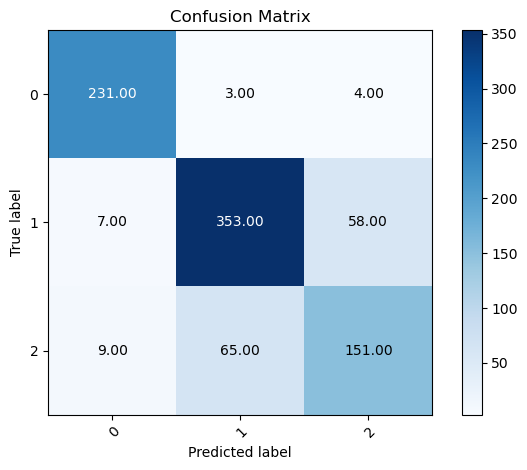

In [25]:
# Create the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Get the unique class labels
classes = unique_labels(true_labels, pred_labels)

# Plot the confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       title='Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the x-axis labels if needed
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over the data and create text annotations
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

# Show the plot
plt.tight_layout()
plt.show()


In [225]:
precision = precision_score(true_labels, pred_labels, average='weighted')
recall = recall_score(true_labels, pred_labels, average='weighted')
f1 = f1_score(true_labels, pred_labels, average='weighted')

# Print the scores
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Precision: 0.8316
Recall: 0.8252
F1 Score: 0.8276


In [226]:
torch.save(model.state_dict(), 'model_assets/model.pt')

In [227]:
model.load_state_dict(torch.load('model_assets/model.pt'))
model.eval() 

ImageClassificationModel(
  (mobilenet): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96,

In [228]:
# set up transforms for your images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

In [229]:
# open the image and convert it to RGB
img = PilImage.open("/home/justin/Desktop/Resume/Github/Pneumonia-image-classification/data/test/normal/NORMAL2-IM-1442-0001.jpeg").convert('RGB')

# resize the image to 224x224
img = img.resize((224, 224))

# apply the specified transforms
img = transform(img)

In [230]:
output = model(img.unsqueeze(0))
_, predicted_class = torch.max(output, 1)

In [231]:
predicted_class.item()

0

In [232]:
import tensorboard